# Machine Learning L05: kNN in Python




![image](https://media.geeksforgeeks.org/wp-content/uploads/20250512162457630554/Finding_Neighbor_Voting_for_Labels.webp)

![KNN](knn.jpg)

## 0 - General Imports

I always find it helpful to put all the imports being used in the notebook into one cell somewhere at the top. This way, it is easy to tell what will be required for running the code in this notebook.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The next line of code will read the CSV file into a Pandas `DataFrame` object so that we have it in our current Python session and can work with it:

In [34]:
df_iris = pd.read_csv('iris.csv')
df_iris.tail()

,Id,SepalLength[cm],SepalWidth[cm],PetalLength[cm],PetalWidth[cm],Species
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica
149,150,5.9,3.0,5.1,1.8,Iris-virginica


## 2 - Get Features into a NumPy Array

In [35]:
X = df_iris[['PetalLength[cm]', 'PetalWidth[cm]']].values
print(X.shape)

(150, 2)


The next cell will show the first 5 entries (examples) in the dataset:

In [36]:
X[:5, :]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

## 3 - Get Class Labels into a NumPy Array

Similary to assigning the features to a new variable `X`, we are now assigning the class lables to a new variable, which we will call `y`. However, before we do that, let us map the class labels from a `string` representation into an `int` (integer) format. For this, we add a new column `ClassLabel` to the data frame:

In [37]:
label_dict = {'Iris-setosa': 0,
              'Iris-versicolor': 1,
              'Iris-virginica': 2}

df_iris['ClassLabel'] = df_iris['Species'].map(label_dict)
df_iris.tail()

,Id,SepalLength[cm],SepalWidth[cm],PetalLength[cm],PetalWidth[cm],Species,ClassLabel
145,146,6.7,3.0,5.2,2.3,Iris-virginica,2
146,147,6.3,2.5,5.0,1.9,Iris-virginica,2
147,148,6.5,3.0,5.2,2.0,Iris-virginica,2
148,149,6.2,3.4,5.4,2.3,Iris-virginica,2
149,150,5.9,3.0,5.1,1.8,Iris-virginica,2


Then, similar to before, we reference the underlying NumPy array via the `.values` attribute and assign it to a variable `y`:

In [38]:
y = df_iris['ClassLabel'].values
y[:116]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2])

The next task is to divide the dataset into a training and a test set. Notice though that the first 10 entries are all zeros. This is because the dataset has not been shuffled yet. Hence, in Iris, the vector `y` will consists of 50 0's, 50 1's, and 50 2's (in that order).

It would thus be a bit problematic if we assigned the first 100 entries to a training set and the 50 last entries to the test set. Can you see why?



## 4 - Shuffle Dataset and Create Training and Test Subsets

In order to divide the dataset into a training and a test set, we are going to shuffle the dataset first. For illustration purposes, we will do this in multiple steps.

In the first step, we create an index array of our dataset:

In [39]:
indices = np.arange(y.shape[0])
indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

Next, we shuffle this index array. Note that we use a random seed such that other people can reproduce the results. This means that if someone else uses this code on a different computer, the person will get the exact same shuffle order.

In [40]:
rnd = np.random.RandomState(123)
shuffled_indices = rnd.permutation(indices)
shuffled_indices

array([ 72, 112, 132,  88,  37, 138,  87,  42,   8,  90, 141,  33,  59,
       116, 135, 104,  36,  13,  63,  45,  28, 133,  24, 127,  46,  20,
        31, 121, 117,   4, 130, 119,  29,   0,  62,  93, 131,   5,  16,
        82,  60,  35, 143, 145, 142, 114, 136,  53,  19,  38, 110,  23,
         9,  86,  91,  89,  79, 101,  65, 115,  41, 124,  95,  21,  11,
       103,  74, 122, 118,  44,  51,  81, 149,  12, 129,  56,  50,  25,
       128, 146,  43,   1,  71,  54, 100,  14,   6,  80,  26,  70, 139,
        30, 108,  15,  18,  77,  22,  10,  58, 107,  75,  64,  69,   3,
        40,  76, 134,  34,  27,  94,  85,  97, 102,  52,  92,  99, 105,
         7,  48,  61, 120, 137, 125, 147,  39,  84,   2,  67,  55,  49,
        68, 140,  78, 144, 111,  32,  73,  47, 148, 113,  96,  57, 123,
       106,  83,  17,  98,  66, 126, 109])

Now that we have the shuffled indices, we can use them to shuffle both the features `X` and `y` relative to each other -- we do this to preserve the correspondence between feature and label in `X` and `y`:

In [41]:
X_shuffled, y_shuffled = X[shuffled_indices], y[shuffled_indices]

In [42]:
y[shuffled_indices]

array([1, 2, 2, 1, 0, 2, 1, 0, 0, 1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 0, 0, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2,
       2, 2, 2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2, 0, 2, 1, 0, 0, 2,
       1, 2, 2, 0, 1, 1, 2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1,
       0, 1, 2, 0, 2, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1,
       1, 1, 2, 1, 1, 1, 2, 0, 0, 1, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 1, 2,
       1, 2, 2, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 0, 1, 1, 2, 2])

Finally, we can divide the dataset into training and test subsets:

In [43]:
X_train, y_train = X_shuffled[:105], y_shuffled[:105]
X_test, y_test = X_shuffled[105:], y_shuffled[105:]

## 5 - Doing Steps 1-4 in Scikit-Learn

Note that we went through a lot of steps in order to load the dataset and to split it into training and test subsets. We did this so that you develop an intuition for the procedure. However, there are also convenient functions in scikit-learn that allow us to do the exact same things in much fewer lines of code. I.e., the following code will load the iris dataset and split it into 30% test data and 70% training data:

In [44]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
iris = load_iris()
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [45]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [46]:
X, y = iris.data[:, 2:], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=123,
                                                    shuffle=True)

In [47]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 2)
y_train.shape: (105,)
X_test.shape: (45, 2)
y_test.shape: (45,)


In [48]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## 6 - Plot Dataset

 the scatterplot function; we can create a scatter plot using matplotlib directly:

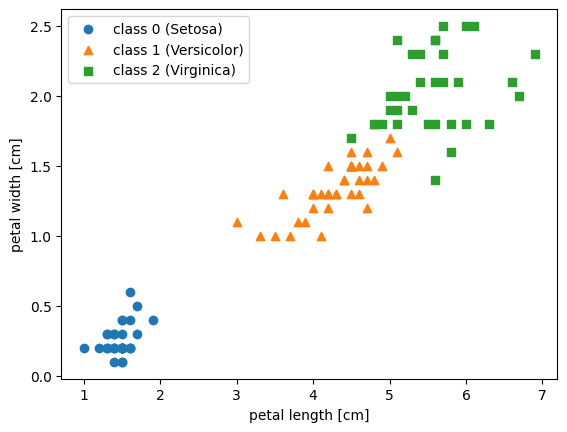

In [49]:
plt.scatter(X_train[y_train == 0, 0],
            X_train[y_train == 0, 1],
            marker='o',
            label='class 0 (Setosa)')

plt.scatter(X_train[y_train == 1, 0],
            X_train[y_train == 1, 1],
            marker='^',
            label='class 1 (Versicolor)')

plt.scatter(X_train[y_train == 2, 0],
            X_train[y_train == 2, 1],
            marker='s',
            label='class 2 (Virginica)')

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.show()

Q: What can you learn about this dataset? Pay close attention to the two axes ...

## 7 - Fit k-Nearest Neighbor Model

Next, we are going to use the `KNeighborsClassifier` class from scikit-learn and instantiate a new KNN object, which we call `knn_model`. Then, we "fit" this model the training dataset:

In [50]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",3
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


Q: What distance measure is used by default?

In [51]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [52]:
# Training accuracy
y_train_pred = knn_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9810


## 8 - Use kNN Model to Make Predictions

After "fitting" the KNN model, we can now make predictions on new data points that the model has not seen before. The test set represents such data points. Of course, we have labels for the test set as well, but we only use these labels to evaluate the model -- i.e., we compare the predictions to the true labels in the test set in order to find out how good the model is:

In [53]:
y_pred = knn_model.predict(X_test)

In [54]:
num_correct_predictions = (y_pred == y_test).sum()
accuracy = (num_correct_predictions / y_test.shape[0]) * 100

# print('Test set accuracy: %.2f%%' % accuracy)

print(f'Test set accuracy: {accuracy:.2f}%')

Test set accuracy: 95.56%


In [55]:
# print('Test set accuracy: %.2f%%' % (knn_model.score(X_test, y_test)*100))

print(f'Test set accuracy: {knn_model.score(X_test, y_test)*100:.2f}%')

Test set accuracy: 95.56%


**Evaluation metrics for the Classification problem**

In [56]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
cm

array([[18,  0,  0],
       [ 0, 10,  0],
       [ 0,  2, 15]])

In [57]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      1.00      0.91        10
           2       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



## 9 - Visualize Decision Boundary

Usually, in machine learning, we work with datasets that have more then 2 feature variables. For educational purposes, however, we chose a very simple dataset consisting of only two features here (the petal length and the petal width of Iris flowers). If we have only two features, we can easily visualize the decision boundary of the model -- here, we will be using a convenience function I implemented in the MLxtend library:

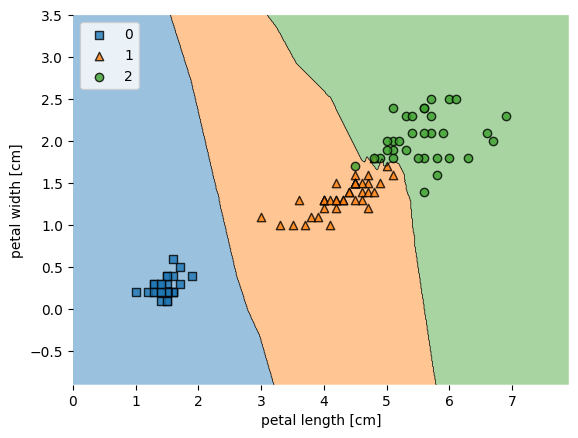

In [58]:
from mlxtend.plotting import plot_decision_regions


plot_decision_regions(X_train, y_train, knn_model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

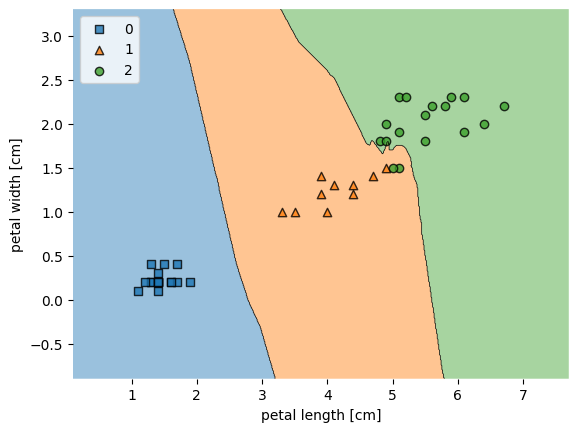

In [59]:
plot_decision_regions(X_test, y_test, knn_model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

# Experimentations with different metrics used in KNN
#                     and Challenges  

## 1. Change K value and distance metrics

In [60]:
from sklearn.neighbors import KNeighborsClassifier
knn_model1 = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=3)  # p2 Euclidean,p1 manhattan,p3 minkowski
#knn_model1 = KNeighborsClassifier(n_neighbors=3, metric='chebyshev') #maximize n=9 ,metric='euclidean
#knn_model1 = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_model1.fit(X_train, y_train)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",9
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",3
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [61]:
print(f'Test set accuracy: {knn_model1.score(X_test, y_test)*100:.2f}%')
y_pred = knn_model1.predict(X_test)
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("Classification Report:\n", classification_report(y_test, y_pred))

Test set accuracy: 95.56%
[[18  0  0]
 [ 0 10  0]
 [ 0  2 15]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      1.00      0.91        10
           2       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



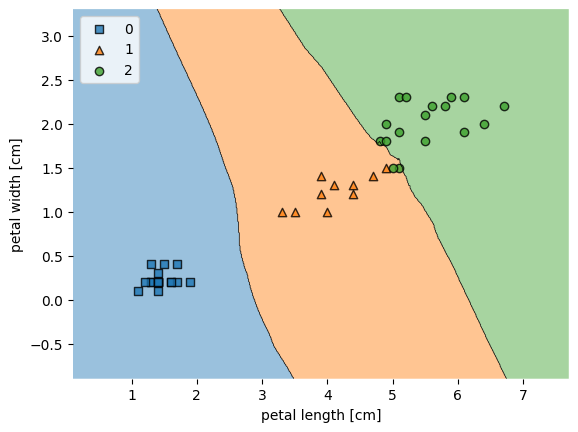

In [62]:
plot_decision_regions(X_test, y_test, knn_model1)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

## 2. Scalling and which Scaller( Standard Scaller and MinMax)

In [63]:
# MinMaxScaller before training
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)
#StandardScaller before training
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaledt = scaler.transform(X_test)
X_scaled

array([[ 0.74020895,  1.5871112 ],
       [ 1.03327811,  1.5871112 ],
       [ 0.09545681,  0.09191264],
       [-1.36988897, -1.26735878],
       [-1.48711663, -1.40328592],
       [ 0.74020895,  1.04340263],
       [-1.25266131, -0.9955045 ],
       [-1.36988897, -1.53921306],
       [ 0.50575363,  0.36376692],
       [ 0.4471398 ,  0.22783978],
       [ 0.09545681,  0.09191264],
       [-0.19761235, -0.31586879],
       [ 0.74020895,  0.90747549],
       [ 0.32991214,  0.22783978],
       [ 0.85743662,  1.45118406],
       [-1.48711663, -1.26735878],
       [ 1.09189194,  1.17932977],
       [ 0.21268447, -0.0440145 ],
       [-1.36988897, -1.13143164],
       [-1.31127514, -1.40328592],
       [ 1.03327811,  0.77154835],
       [ 0.2712983 ,  0.09191264],
       [ 1.67803026,  1.04340263],
       [ 1.79525792,  1.45118406],
       [-1.13543365, -1.13143164],
       [ 0.38852597,  0.36376692],
       [-0.08038468, -0.31586879],
       [ 0.74020895,  0.77154835],
       [-1.4285028 ,

## 3. Class Imbalanced

In [64]:
## Handle Class Imbalance with SMOTE
from imblearn.over_sampling import SMOTE
print("Class distribution before SMOTE:", np.bincount(y_train))
smote = SMOTE(random_state=42)
X_train_scaled, y_train = smote.fit_resample(X_scaled, y_train)
print("Class distribution after SMOTE:", np.bincount(y_train))

ModuleNotFoundError: No module named 'imblearn'

In [ ]:
## Model training
from sklearn.neighbors import KNeighborsClassifier
knn_model2 = KNeighborsClassifier(n_neighbors=9, metric='minkowski', p=2)  # p2 Euclidean,p1 manhattan,p3 minkowski

#metric='chebyshev') #maximize n=9 ,metric='euclidean
#knn_model2 = KNeighborsClassifier(n_neighbors=3, metric='cosine')

knn_model2.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=9)

In [ ]:
# Training accuracy
y_train_pred2 = knn_model2.predict(X_train_scaled)
train_accuracy2 = accuracy_score(y_train, y_train_pred2)
print(f"Training Accuracy: {train_accuracy2:.4f}")

Training Accuracy: 0.9750


In [ ]:
knn_uniform = KNeighborsClassifier(n_neighbors=5, weights="uniform")
knn_distance = KNeighborsClassifier(n_neighbors=5, weights="distance")